In [1]:
import mitsuba as mi
import drjit as dr
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

mi.set_variant('cuda_ad_rgb')

In [2]:
# 1. Load the scene (as you already have)
scene = mi.load_file('./simple.xml')
original_scene_rendered = mi.render(scene, spp=256)
mi.util.convert_to_bitmap(original_scene_rendered)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [3]:
# 2. Load a native "ground truth" integrator
# 'path' is the standard path tracer. 'max_depth' is like in a normal render.
integrator = mi.load_dict({
    'type': 'path',
    'max_depth': 8    # How many bounces to simulate. Set to a high value for good results
})

# 3. Load a sampler
# We'll re-seed this sampler inside the loop
sampler = mi.load_dict({
    'type': 'independent',
    'sample_count': 1,
})


In [4]:
for shape in scene.shapes():
    print(shape)

Sphere[
  to_world = [[3, 0, 0, 0],
              [0, 3, 0, 2],
              [0, 0, 3, 0],
              [0, 0, 0, 1]],
  center = [0, 2, 0],
  radius = 3,
  surface_area = [113.097],
  bsdf = SmoothDiffuse[
    reflectance = SRGBReflectanceSpectrum[
      value = [[0.8, 0.2, 0.2]]
    ]
  ]
]


In [5]:
# https://github.com/krafton-ai/neural-radiosity-tutorial-mitsuba3/blob/main/neural_radiosity.ipynb


In [6]:
# discard delta surfaces (e.g., perfect mirror)
m_area = []
for shape in scene.shapes():
    if not shape.is_emitter() and mi.has_flag(shape.bsdf().flags(), mi.BSDFFlags.Smooth):
        m_area.append(shape.surface_area())
    else:
        m_area.append([0])
m_area = np.array(m_area)[:, 0]
if len(m_area):
    m_area /= m_area.sum()
else:
    raise Warning("No smooth shape. No need of neural network training.")

print("m_area", m_area, "\n")
print("Print discarded surfaces:")
for i, area in enumerate(m_area):
    if area == 0:
        print("index: ", i)
        print("emitter?: ", scene.shapes()[i].is_emitter())
        print("bsdf: ", scene.shapes()[i].bsdf(), "\n")

m_area [1.] 

Print discarded surfaces:


In [7]:
shape_sampler = mi.DiscreteDistribution(m_area)

def sample_si(scene, shape_sampler, sample1, sample2, sample3, active=True):
    """Sample a batch of surface interactions with bsdfs.

    Args:
        scene (mitsuba.Scene): the underlying scene
        shape_sampler (mi.DiscreteDistribution): a source of random numbers for shape sampling
        sample1 (drjit.llvm.ad.Float): determines mesh surfaces
        sample2 (mitsuba.Point2f): determines positions on the meshes
        sample3 (mitsuba.Point2f): determines directions at the positions
        active (bool, optional): mask to specify active lanes. Defaults to True.

    Returns:
        mitsuba.SurfaceInteraction3f
    """
    shape_indices = shape_sampler.sample(sample1, active)
    shapes = dr.gather(mi.ShapePtr, scene.shapes_dr(), shape_indices, active)

    ps = shapes.sample_position(0, sample2, active)
    si = mi.SurfaceInteraction3f(ps, dr.zeros(mi.Color0f))
    si.shape = shapes
    si.t = mi.Float(si.time*0)

    active_two_sided = mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.BackSide)
    si.wi = dr.select(
        active_two_sided,
        mi.warp.square_to_uniform_sphere(sample3),
        mi.warp.square_to_uniform_hemisphere(sample3),
    )

    return si

In [8]:
# helper functions for visualization
def world_to_ndc(scene, batch):
    """Transforms 3D world coordinates into normalized device coordinates (NDC) using the perspective transformation matrix.

    # Args
        scene (mi.Scene): Mitsuba 3 scene containing the camera information.
        batch (array_like): Array of 3D world coordinates.

    Returns:
        mi.Point3f: Array of 3D points in NDC.
    """
    sensor = mi.traverse(scene.sensors()[0])
    trafo = mi.Transform4f.perspective(fov=sensor['x_fov'], near=sensor['near_clip'], far=sensor['far_clip'])
    pts = trafo @ sensor['to_world'].inverse() @ mi.Point3f(np.array(batch))
    return pts

def ndc_to_pixel(pts, h, w):
    """Converts points in NDC to pixel coordinates.

    Args:
        pts (mi.Point2f): Points in NDC.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given points.
    """
    hh, hw = h/2, w/2
    return mi.Point2f(dr.fma(pts.x, -hw, hw), dr.fma(pts.y, -hw, hh))  # not typo

def draw_multi_segments(starts, ends, color):
    """Draws multiple line segments on a plot.

    Args:
        starts (mi.Point2f): Starting points of the line segments.
        ends (mi.Point2f): Ending points of the line segments.
        color (str): Color of the line segments.
    """
    a = np.c_[starts.x, starts.y]
    b = np.c_[ends.x, ends.y]
    plt.plot(*np.c_[a, b, a*np.nan].reshape(-1, 2).T, color)

def pix_coord(scene, batch, h, w):
    """Calculates the pixel coordinates of the given 3D world coordinates.

    Args:
        scene (mi.Scene): Mitsuba 3 scene containing the camera information.
        batch (array_like): Array of 3D world coordinates.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given 3D world coordinates.
    """
    return ndc_to_pixel(world_to_ndc(scene, batch), h, w)

def draw_si(si, ax, original_image, marker=".", color="red"):
    """Draws the surface interaction on a plot.

    Args:
        si (mi.SurfaceInteraction): Surface interaction to be drawn.
        ax (matplotlib.axes.Axes): The axes object to plot the surface interaction on.
        original_image (np.ndarray): The original image to plot on the axes.
        marker (str): Marker style for the plot.
        color (str): Color for the plot.
    """
    h, w = original_image.shape[0], original_image.shape[1] 
    x_pix = pix_coord(scene, si.p, h, w)
    wi_pix = pix_coord(scene, dr.fma(si.to_world(si.wi), 0.25, si.p), h, w)
    n_pix = pix_coord(scene, dr.fma(si.n, 0.25, si.p), h, w)

    # draw directions
    draw_multi_segments(x_pix, n_pix, 'green')
    draw_multi_segments(x_pix, wi_pix, 'magenta')

    ax.scatter(x_pix.x, x_pix.y, marker=marker, color=color)
    plt.scatter(n_pix.x, n_pix.y, marker='.', color='green')
    plt.scatter(wi_pix.x, wi_pix.y, marker='x', color='magenta')

    # Add index labels to surface interaction points
    batch_size = dr.width(si)
    for idx in range(batch_size):
        ax.text(x_pix.x[idx]+5, x_pix.y[idx]+5, str(idx), fontsize=10, color="white", fontweight='bold')
    
    ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

def draw_moving_arrow(si, h, w, si_prev, ax):
    """Draws a moving arrow on a plot to represent the surface interaction movement.

    Args:
        si (mi.SurfaceInteraction): Surface interaction to be drawn.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.
        si_prev (mi.SurfaceInteraction): Previous surface interaction to connect to the current one.
        ax (matplotlib.axes.Axes): The axes object to plot the moving arrow on.
    """
    x_pix = pix_coord(scene, si.p, h, w)
    x_prev_pix = pix_coord(scene, si_prev.p, h, w)
    draw_multi_segments(x_prev_pix, x_pix, 'green')


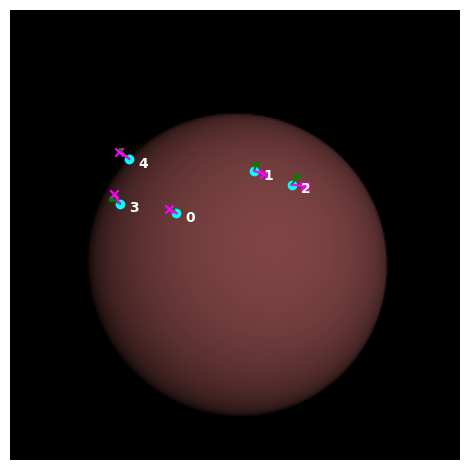

In [9]:

# sample only on the second shape, i.e., the glass ball
tmp_area = [0] * len(m_area)
tmp_area[0] = 1
tmp_shape_sampler = mi.DiscreteDistribution(tmp_area)

seed = 42
l_sampler = sampler.clone()
l_sampler.seed(seed, 5)  # sample five points

si = sample_si(
    scene, tmp_shape_sampler, 
    l_sampler.next_1d(), l_sampler.next_2d(), l_sampler.next_2d()
)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
draw_si(si, ax, original_scene_rendered, marker="o", color="cyan")
# green is the normal
# magenta is w_in

In [10]:
import plotly.graph_objects as go
import plotly.express as px

def draw_si_3d(scene, si, original_image_rgb, marker_size=5, marker_color="cyan"):
    """Draws the surface interaction in 3D with interactive rotation.
    
    Args:
        scene (mi.Scene): Mitsuba scene
        si (mi.SurfaceInteraction3f): Batched surface interactions
        original_image_rgb (np.ndarray): Original rendered image (for reference/title)
        marker_size (int): Size of scatter markers
        marker_color (str): Color of surface points
    """
    batch_size = dr.width(si)
    
    # Extract 3D positions and directions
    positions = np.array(si.p)  # (N, 3)
    normals = np.array(si.n)    # (N, 3)
    wi_world = np.array(si.to_world(si.wi))  # (N, 3)
    
    # Create figure
    fig = go.Figure()
    
    # Plot surface interaction points
    fig.add_trace(go.Scatter3d(
        x=positions[:, 0],
        y=positions[:, 1],
        z=positions[:, 2],
        mode='markers+text',
        marker=dict(size=marker_size, color=marker_color, symbol='circle'),
        name='Surface Points',
        text=[f"Point {i}" for i in range(batch_size)],
        hoverinfo='text',
        textfont=dict(
            color='black', 
            size=10        
        )     
    ))
    
    # Plot normals (green arrows)
    scale = 0.5
    for i in range(batch_size):
        fig.add_trace(go.Scatter3d(
            x=[positions[i, 0], positions[i, 0] + normals[i, 0] * scale],
            y=[positions[i, 1], positions[i, 1] + normals[i, 1] * scale],
            z=[positions[i, 2], positions[i, 2] + normals[i, 2] * scale],
            mode='lines',
            line=dict(color='green', width=4),
            name='Normals',
            showlegend=(i == 0),
            hoverinfo='skip'
        ))
    
    # Plot incident directions (magenta arrows)
    for i in range(batch_size):
        fig.add_trace(go.Scatter3d(
            x=[positions[i, 0], positions[i, 0] + wi_world[i, 0] * scale],
            y=[positions[i, 1], positions[i, 1] + wi_world[i, 1] * scale],
            z=[positions[i, 2], positions[i, 2] + wi_world[i, 2] * scale],
            mode='lines',
            line=dict(color='magenta', width=4),
            name='Incident Direction' if i == 0 else '',
            showlegend=(i == 0),
            hoverinfo='skip'
        ))
    
    # Add the sphere geometry for reference
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    sphere_x = 3.0 * np.outer(np.cos(u), np.sin(v)) + 0  # center at (0, 2, 0)
    sphere_y = 3.0 * np.outer(np.sin(u), np.sin(v)) + 2
    sphere_z = 3.0 * np.outer(np.ones(np.size(u)), np.cos(v)) + 0
    
    fig.add_trace(go.Surface(
        x=sphere_x, y=sphere_y, z=sphere_z,
        opacity=0.3,
        colorscale='Greys',
        showscale=False,
        name='Sphere',
        hoverinfo='skip'
    ))
    

    
    # Add camera from simple.xml: origin="0.0, -12.0, 5.0", target="0.0, 0.0, 1.25"
    camera_pos = np.array([0.0, -12.0, 5.0])
    camera_target = np.array([0.0, 0.0, 1.25])
    camera_dir = camera_target - camera_pos
    camera_dir = camera_dir / np.linalg.norm(camera_dir)
    
    # Draw camera position (blue dot)
    fig.add_trace(go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=10, color='blue', symbol='diamond'),
        name='Camera',
        hoverinfo='text',
        hovertext='Camera Position'
    ))
    
    # Draw camera viewing direction (blue arrow)
    arrow_length = 3.0
    fig.add_trace(go.Scatter3d(
        x=[camera_pos[0], camera_pos[0] + camera_dir[0] * arrow_length],
        y=[camera_pos[1], camera_pos[1] + camera_dir[1] * arrow_length],
        z=[camera_pos[2], camera_pos[2] + camera_dir[2] * arrow_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Camera View',
        showlegend=True,
        hoverinfo='skip'
    ))
    
    # Add light from simple.xml: position="3, -10.0, 6.0"
    light_pos = np.array([3.0, -10.0, 6.0])
    
    # Draw light position (yellow diamond)
    fig.add_trace(go.Scatter3d(
        x=[light_pos[0]], y=[light_pos[1]], z=[light_pos[2]],
        mode='markers+text',
        marker=dict(size=12, color='yellow', symbol='diamond', 
                   line=dict(color='orange', width=2)),
        text=['Light'],
        textposition='top center',
        name='Light Source',
        hoverinfo='text',
        hovertext='Point Light: intensity=100.0'
    ))
    
    # Update layout
    fig.update_layout(
        title="3D Surface Interactions (Green=Normal, Magenta=Incident Direction)",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode='data'
        ),
        width=900,
        height=900,
        showlegend=True,
        hovermode='closest'
    )
    
    fig.show()

# Usage:
draw_si_3d(scene, si, original_scene_rendered)

In [12]:
def get_ground_truth_radiance(scene, integrator, sampler, si, num_samples=8):
    """Sample radiance for batched surface interactions.
    
    Args:
        scene (mi.Scene): Scene containing geometry and lights
        integrator (mi.Integrator): Path tracer integrator
        sampler (mi.Sampler): Independent sampler
        si (mi.SurfaceInteraction3f): Batched surface interactions
        num_samples (int): Number of samples per surface point
        
    Returns:
        mi.Spectrum: Batched radiance values
    """
    batch_size = dr.width(si)
    
    ray_direction = si.to_world(si.wi)
    # Negate: we want to shoot rays BACKWARD along the incident direction
    # so the integrator sees them as incoming light
    ray_direction = -ray_direction
    
    eps = 1e-4
    ray_origin = si.p + si.n * eps  # offset along normal to avoid self-intersection
    query_ray = mi.Ray3f(o=ray_origin, d=ray_direction)
    
    # Initialize spectrum with same batch size as surface interactions
    L = dr.zeros(mi.Spectrum, batch_size)
    
    # Run the high-SPP loop
    for i in range(num_samples):
        sampler.seed(i, 1)
        L_sample, is_valid, _ = integrator.sample(scene, sampler, query_ray)
        L[is_valid] += L_sample[is_valid]

        # NOTE: above does not account for surface BRDF reflecting incoming light
        # To account for full outgoing radiance, need to apply your surface's BRDF to the incoming radiance
        # i.e. bsdf_val = BRDF * cos(theta) evaluated at si.wi
        # bsdf = si.bsdf()
        # ctx = mi.BSDFContext()
        # bsdf_val = bsdf.eval(ctx, si, si.wi)
        # L[is_valid] += L_sample[is_valid] * bsdf_val[is_valid]
            
    return L / num_samples


# Now use it with your batched si:
L = get_ground_truth_radiance(scene, integrator, sampler, si, num_samples=16)
print(f"Radiance values shape: {dr.shape(L)}")
print(f"Radiance values:\n {L}")

Radiance values shape: [3, 5]
Radiance values:
 [[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.18647393584251404, 0.04661848396062851, 0.04661848396062851],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]


In [13]:
si

SurfaceInteraction[
  t = [0, 0, 0, 0, 0],
  time = [0, 0, 0, 0, 0],
  wavelengths = [],
  p = [[-1.39585, 4.63092, 0.360358],
       [0.425145, 4.63615, 1.36746],
       [0.941812, 0.101864, 2.12369],
       [-2.5032, 3.36802, 0.928715],
       [-2.06889, 2.0481, 2.17195]],
  shape = [0x7f6d540023c0, 0x7f6d540023c0, 0x7f6d540023c0, 0x7f6d540023c0, 0x7f6d540023c0],
  uv = [[0.327635, 0.43994],
        [0.224551, 0.27209],
        [0.823304, 0.146051],
        [0.420398, 0.345214],
        [0.496301, 0.138008]],
  n = [[-0.465285, 0.876973, 0.120119],
       [0.141715, 0.878717, 0.455821],
       [0.313937, -0.632712, 0.707897],
       [-0.834401, 0.456005, 0.309572],
       [-0.689631, 0.0160328, 0.723984]],
  sh_frame = Frame[
    s = [[0.806726, 0.364284, 0.465285],
         [0.986205, -0.0855376, -0.141715],
         [0.942294, 0.116302, -0.313937],
         [0.468357, 0.290546, 0.834401],
         [0.724133, 0.00641348, 0.689631]],
    t = [[0.364284, 0.313393, -0.876973],
        